# Libraries

In [1]:
from __future__ import division, print_function
from importlib import import_module

import os
import sys
import numpy as np
from numpy.polynomial.polynomial import polyval
import scipy.io as sio
import matplotlib.pyplot as plt
import math
from math import pi

# Import tqdm (progress bar)
try:
    library = import_module('tqdm')
except:
    print(sys.exc_info())
else:
    globals()['tqdm'] = library

from lib import *

from IPython.display import clear_output
%matplotlib inline

# Directories

In [2]:
# Data files
name_folder_im = 'matlab2'
name_folder_ex = 'export'
name_export = 'matlab1_stab'

# Directory
dir_main = os.getcwd()
dir_folder_im = os.path.join(dir_main, 'data', name_folder_im)
dir_file_ex = os.path.join(dir_main, 'data', name_folder_ex, name_export)

# List files
mat_list = os.listdir(dir_folder_im)

# Set-up

In [3]:
asy = 0.1

# Import Data

In [4]:
# Progress bar
try:
    total = len(mat_list)
    pbar = tqdm.tqdm(total=total)
    up_num = 1            
except:
    print('tqmb package missing! No progress bar defined.')
    is_bar = False
else:
    is_bar = True

# Tuple list (later meshes)
stab_list = []

for k in range(len(mat_list)):
    dir_mat = os.path.join(dir_folder_im, mat_list[k])
    dict_mat = sio.loadmat(dir_mat)
    
    # Solution
    sol = {}
    sol['t'] = np.reshape(dict_mat['t'], -1)
    sol['y'] = dict_mat['y']
    sol['yp'] = dict_mat['yp']
    
    sol['gain'] = dict_mat['gain'][0,0]
    sol['T'] = dict_mat['T'][0,0]
    
    # Compute the global frequency:
    arr_omega = asylib.weight_avg(sol['t'], sol['yp'], asy)
    Omega = np.sum(arr_omega) / arr_omega.size
    
    Omega_vars = asylib.weight_avg(sol['t'], (sol['yp'] - Omega)**2, asy)
    Omega_var = np.sum(Omega_vars)
    
    # Get array of asymptotic phases:
    arr_lin = Omega*sol['t']
    arr_lin = arr_lin[:,None]

    arr_diff = sol['y'] - arr_lin
    asy_phases = asylib.weight_avg(sol['t'], arr_diff, asy)
    phase_var = asylib.weight_avg(sol['t'], (arr_diff - asy_phases)**2, asy)
    phase_var = np.sum(phase_var)
    
    # Store
    stab_list.append((sol['T'], sol['gain'], Omega_var, phase_var))
    
    # Update progress bar (pbar):
    if is_bar:
        pbar.update(up_num)    

 94%|███████████████████████████████████████▎  | 72/77 [00:01<00:00, 55.70it/s]

# Convert to mesh arrays (for dotted heatmap)

In [5]:
T_list = []
gain_list = []

for k in range(len(stab_list)):
    p = stab_list[k]
    
    if p[0] not in T_list:
        T_list.append(p[0])
    if p[1] not in gain_list:
        gain_list.append(p[1])
    
# Sort in increasing order
T_list.sort()
gain_list.sort()

# Create meshes
gain_mesh, T_mesh = np.meshgrid(np.array(gain_list), np.array(T_list)) 
var_mesh = np.zeros(gain_mesh.shape)

# Fill error (var) mesh:
for j in range(len(stab_list)):
    
    # Find indices m, n:
    T = stab_list[j][0]
    gain = stab_list[j][1]
    var = stab_list[j][2] + stab_list[j][3]
    
    m = np.where(np.array(T_list) == T)
    n = np.where(np.array(gain_list) == gain)
    
    var_mesh[m,n] = var

# Plot

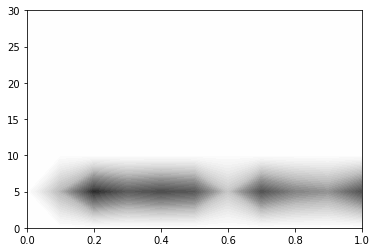

In [21]:
fig, ax = plt.subplots(1,1)

ax.set_xlim(T_list[0], T_list[-1])
ax.set_ylim(gain_list[0], gain_list[-1])

L_var = 0
U_var = 2.5
alpha = 1.0

levels = np.linspace(L_var, U_var, 40)

ax.contourf(T_mesh, gain_mesh, var_mesh, levels, cmap='Greys', alpha=alpha)

In [7]:
gain_list[1]

array([[3.26726696e-05, 3.26726696e-05, 3.26726696e-05, 3.26726696e-05,
        3.26726696e-05, 3.26726696e-05, 3.26726696e-05],
       [6.17649230e-04, 9.76899565e-01, 1.99649046e-02, 9.32607882e-04,
        1.39619087e-04, 8.11220327e-05, 2.84271685e-05],
       [6.30480465e-05, 2.12927915e+00, 1.49456560e-02, 6.79673154e-04,
        1.44272506e-04, 5.63677646e-05, 1.80753162e-04],
       [1.96344488e-06, 1.76025900e+00, 2.46690283e-02, 8.71638863e-04,
        1.81339876e-04, 3.58776323e-04, 8.70611846e-05],
       [1.58344481e-06, 1.90001758e+00, 2.15019491e-02, 8.78106059e-04,
        4.68443485e-04, 1.73879432e-04, 1.22003648e-04],
       [1.08584982e-03, 1.79619170e+00, 2.69729052e-02, 1.26104025e-03,
        8.04965585e-05, 1.02509983e-04, 5.77895071e-05],
       [1.11592450e-04, 8.10491026e-01, 2.80986488e-02, 1.36653448e-03,
        6.97747329e-04, 1.50712562e-04, 1.96462304e-04],
       [4.69170304e-04, 1.84932589e+00, 2.45375550e-02, 2.63064793e-03,
        6.97049049e-04, 2

In [16]:
stab_list

[(0.1, 0, 0.00013076495566096365, 0.0004868842746626768),
 (0.1, 10, 0.009095850105779688, 0.010869054463351211),
 (0.1, 15, 0.000325579004744504, 0.000607028877672812),
 (0.1, 20, 3.5039250002110527e-05, 0.00010457983679352227),
 (0.1, 25, 1.9063668830005113e-05, 6.205836387687748e-05),
 (0.1, 30, 6.112868753433592e-06, 2.231429975877551e-05),
 (0.1, 5, 0.39671254801316214, 0.5801870166073885),
 (0.2, 0, 1.6740999863193528e-05, 4.630704666966866e-05),
 (0.2, 10, 0.007272393913050635, 0.007673262078313019),
 (0.2, 15, 0.00030090692566672744, 0.0003787662278488671),
 (0.2, 20, 4.208339239381415e-05, 0.00010218911339312739),
 (0.2, 25, 1.3073637173495112e-05, 4.329412738511628e-05),
 (0.2, 30, 4.05057277405082e-05, 0.00014024743431518728),
 (0.2, 5, 1.3902448328091734, 0.739034319078442),
 (0.30000000000000004, 0, 2.929660415764983e-07, 1.6704788378261122e-06),
 (0.30000000000000004, 10, 0.012205403501856974, 0.01246362481814307),
 (0.30000000000000004, 15, 0.00039671197435422204, 0.0004